In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
import torch.optim as optim
import torch.nn as nn
from autoencoder_model import REDNet10, REDNet20, REDNet30, REDNet10_W256
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../lib")))
from utils import get_split_datapaths, psnr, init_logging, assess_model
from dataloader import PassiveMicrowaveDataset
import torch
from torch.utils.data import Dataset, DataLoader
import xarray as xr
import numpy as np
import cv2
from torchvision.transforms import ToTensor
from skimage.metrics import structural_similarity as ssim


from datetime import datetime

logger = init_logging()

In [2]:
train_paths, val_paths, test_paths = get_split_datapaths()

2025-05-23 11:02:13,447 - root - INFO - Warning: Directory /lustre/storeB/project/metkl/DigitalSeaIce/are-phd/SuperResolutionSeaIce/Dataset/AMSRSSMI/2011/11 does not exist. Skipping...
2025-05-23 11:02:13,447 - root - INFO - Warning: Directory /lustre/storeB/project/metkl/DigitalSeaIce/are-phd/SuperResolutionSeaIce/Dataset/AMSRSSMI/2011/11 does not exist. Skipping...
2025-05-23 11:02:13,448 - root - INFO - Warning: Directory /lustre/storeB/project/metkl/DigitalSeaIce/are-phd/SuperResolutionSeaIce/Dataset/AMSRSSMI/2011/12 does not exist. Skipping...
2025-05-23 11:02:13,448 - root - INFO - Warning: Directory /lustre/storeB/project/metkl/DigitalSeaIce/are-phd/SuperResolutionSeaIce/Dataset/AMSRSSMI/2011/12 does not exist. Skipping...
2025-05-23 11:02:13,449 - root - INFO - Warning: Directory /lustre/storeB/project/metkl/DigitalSeaIce/are-phd/SuperResolutionSeaIce/Dataset/AMSRSSMI/2012/01 does not exist. Skipping...
2025-05-23 11:02:13,449 - root - INFO - Warning: Directory /lustre/storeB/p

In [3]:
# Initialize test dataset with normalization
test_dataset = PassiveMicrowaveDataset(test_paths, transform=ToTensor(), normalize=True, use_bicubic=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
# from skimage.metrics import peak_signal_noise_ratio as scikit_PSNR

def plot_single_sample(model_pth, test_paths, test_dataset, sample_idx, device="cuda" if torch.cuda.is_available() else "cpu", mask_land =False, denormalize = True):
    """
    Plot a single test sample's low-resolution input, high-resolution ground truth, 
    and model output along with the PSNR and MSE.
    """
    time = test_paths[sample_idx].split("_")[-1].replace(".nc","")
    dt = datetime.strptime(str(time), "%Y%m%d%H")
    dt.strftime("%Y-%m-%d %H:00")
    print(dt)
    if "REDNet10" in model_pth.split("_")[1].split("/"):
        model = REDNet10()
    elif "REDNet20" in model_pth.split("_")[1].split("/"):
        model = REDNet20()
    elif "REDNet30" in model_pth.split("_")[1].split("/"):
        model = REDNet30()
    elif "REDNet256" in model_pth.split("_")[1].split("/"):
        model = REDNet10_W256()

    model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))
    model.eval()  # Set the model to evaluation mode

    # Get a single test sample
    low_res, high_res = test_dataset[sample_idx]

    # Convert to batch format and move to device
    low_res_tensor = low_res.clone().detach().unsqueeze(0).to(device)
    high_res_tensor = high_res.clone().detach().unsqueeze(0).to(device)

    # Run model inference
    with torch.no_grad():
        output = model(low_res_tensor)

    # Move data back to CPU and convert to NumPy
    if denormalize:
        low_res = test_dataset.denormalize(low_res_tensor.squeeze(0)).cpu().numpy()
        high_res = test_dataset.denormalize(high_res_tensor.squeeze(0)).cpu().numpy()
        output = test_dataset.denormalize(output.squeeze(0)).cpu().numpy()
    else:
        low_res = low_res_tensor.squeeze(0).cpu().numpy()
        high_res = high_res_tensor.squeeze(0).cpu().numpy()
        output = output.squeeze(0).cpu().numpy()

    filtered_low_res_v = low_res[0][low_res[0] > 0]
    filtered_high_res_v = high_res[0][high_res[0] > 0]
    combined_filtered_v = np.concatenate([filtered_low_res_v, filtered_high_res_v])
    v_min = np.min(combined_filtered_v)
    v_max = np.max(combined_filtered_v)

    filtered_low_res_h = low_res[1][low_res[1] > 0]
    filtered_high_res_h = high_res[1][high_res[1] > 0]
    combined_filtered_h = np.concatenate([filtered_low_res_h, filtered_high_res_h])
    h_min = np.min(combined_filtered_h)
    h_max = np.max(combined_filtered_h)

    if mask_land:
        output[0][output[0] < v_min] = 0
        output[1][output[1] < h_min] = 0

    psnr_value_v = psnr(torch.tensor(output[0]), torch.tensor(high_res[0]), pol="V").item()
    # scikit_psnr_v = scikit_PSNR(output[0], high_res[0], data_range=pol_max_val['V'])
    psnr_baseline_v = psnr(torch.tensor(low_res[0]), torch.tensor(high_res[0]), pol="V").item()
    # scikit_psnr_baenline_v = scikit_PSNR(high_res[0], low_res[0], data_range=pol_max_val['V'])
    psnr_value_h = psnr(torch.tensor(output[1]), torch.tensor(high_res[1]), pol="H").item()
    psnr_baseline_h = psnr(torch.tensor(low_res[1]), torch.tensor(high_res[1]), pol="H").item()

    # SSIM
    ssim_low_res_v = ssim(high_res[0], low_res[0], data_range=low_res[0].max() - low_res[0].min())
    ssim_low_res_h = ssim(high_res[1], low_res[1], data_range=low_res[1].max() - low_res[1].min())
    ssim_output_v = ssim(high_res[0], output[0], data_range=output[0].max() - output[0].min())
    ssim_output_h = ssim(high_res[1], output[1], data_range=output[1].max() - output[1].min())

    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    
    # V-pol comparison
    im1 = axs[0, 0].imshow(low_res[0], cmap='jet', vmin=v_min, vmax=v_max)
    axs[0, 0].axis('off')
    axs[0, 0].set_title("Low-Res SSMI 37 GHz (Input)")
    axs[0, 0].text(0.7, 0.9, f"PSNR: {psnr_baseline_v:.3f}\nSSIM: {ssim_low_res_v:.3f}", color='white', ha='left', va='bottom', transform=axs[0, 0].transAxes)

    im2 = axs[0, 1].imshow(high_res[0], cmap='jet', vmin=v_min, vmax=v_max)  # Ground Truth
    axs[0, 1].axis('off')
    axs[0, 1].set_title("High-Res AMSR 37 GHz (Ground Truth)")

    im3 = axs[0, 2].imshow(output[0], cmap='jet', vmin=v_min, vmax=v_max)  # Autoencoder Output
    axs[0, 2].axis('off')
    axs[0, 2].set_title("Autoencoder Output")
    axs[0, 2].text(0.7, 0.9, f"PSNR: {psnr_value_v:.3f}\nSSIM: {ssim_output_v:.3f}", color='white', ha='left', va='bottom', transform=axs[0, 2].transAxes)

    # H-pol comparison
    im4 = axs[1, 0].imshow(low_res[1], cmap='jet', vmin=h_min, vmax=h_max)
    axs[1, 0].axis('off')
    axs[1, 0].set_title("")
    axs[1, 0].text(0.7, 0.9, f"PSNR: {psnr_baseline_h:.3f}\nSSIM: {ssim_low_res_h:.3f}", color='white', ha='left', va='bottom', transform=axs[1, 0].transAxes)

    im5 = axs[1, 1].imshow(high_res[1], cmap='jet', vmin=h_min, vmax=h_max)  # Ground Truth
    axs[1, 1].axis('off')
    axs[1, 1].set_title("")

    im6 = axs[1, 2].imshow(output[1], cmap='jet', vmin=h_min, vmax=h_max)  # Autoencoder Output
    axs[1, 2].axis('off')
    axs[1, 2].set_title("")
    axs[1, 2].text(0.7, 0.9, f"PSNR: {psnr_value_h:.3f}\nSSIM: {ssim_output_h:.3f}", color='white', ha='left', va='bottom', transform=axs[1, 2].transAxes)

    axs[0, 0].annotate("V-Pol", xy=(-0.05, 0.5), xycoords='axes fraction', fontsize=12, ha='center', va='center', rotation=90)
    axs[1, 0].annotate("H-Pol", xy=(-0.05, 0.5), xycoords='axes fraction', fontsize=12, ha='center', va='center', rotation=90)

    # Add colorbars outside the plot
    cbar_ax1 = fig.add_axes([0.9, 0.46, 0.02, 0.415])  # Top row
    cbar_ax2 = fig.add_axes([0.9, 0.025, 0.02, 0.415])  # Bottom row
    fig.colorbar(im2, cax=cbar_ax1, label='Brightness Temperature (K)')
    fig.colorbar(im5, cax=cbar_ax2, label='Brightness Temperature (K)')
    # Adjust layout to avoid overlap
    plt.tight_layout(rect=[0, 0, .9, .92])
    # plt.show()

**NOTE** All pixels with nan i.e. 0 in LR han HR are 126.078224 in output (mean val from denormalizing)

2020-02-16 12:00:00


/tmp/ipykernel_1860876/845444925.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))
<frozen 

2025-05-15 09:04:17,726 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-05-15 09:04:17,726 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-05-15 09:04:17,731 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-05-15 09:04:17,731 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-05-15 09:04:17,738 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-05-15 09:04:17,738 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-05-15 09:04:17,740 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/home/alessioc/.conda/envs/FYS5429/lib/python3.12/site-packages/matplotlib/mp

/tmp/ipykernel_1860876/845444925.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, .92])


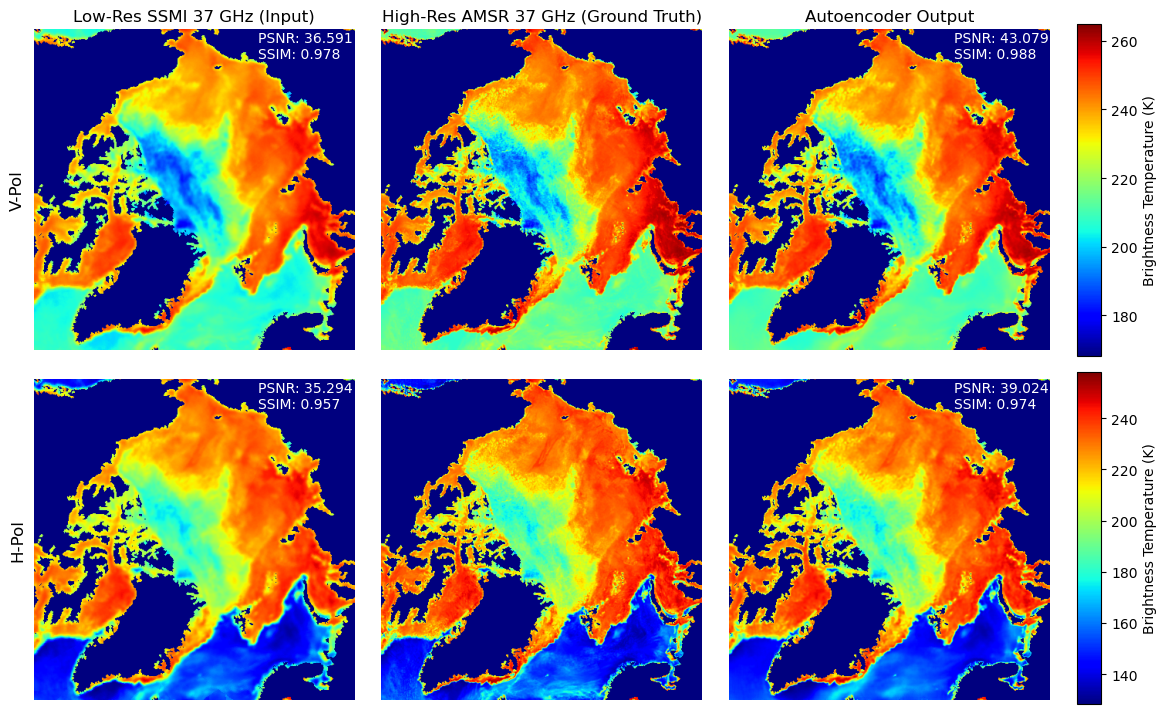

In [5]:
model_pth = "trained_models/REDNet256_24h_batchsize8_samplesall_normalized.pth"
plot_single_sample(model_pth,
                   test_paths,
                   test_dataset,
                   sample_idx=40,
                   mask_land=True);

2020-05-24 12:00:00


/tmp/ipykernel_3028909/3872938609.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))


<class 'torch.Tensor'>
tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.9463, 1.0254, 1.0130],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.1220],
          [0.9161, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.8505, 0.8548, 0.8472,  ..., 0.0000, 0.0000, 0.0000],
          [0.8467, 0.8469, 0.8492,  ..., 0.0000, 0.0000, 0.0000],
          [0.8458, 0.8550, 0.8472,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.4365, 0.6350, 0.5863],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.8769],
          [0.3974, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.3257, 0.3284, 0.3237,  ..., 0.0000, 0.0000, 0.0000],
          [0.3229, 0.3392, 0.3321,  ..., 0.0000, 0.0000, 0.0000],
          [0.3201, 0.3353, 0.3356,  ..., 0.0000, 0.0000, 0.0000]]]])
2025-05-12 10:54:17,891 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fb8ae264a40>
2025-05-12 10:54:17,891 - ma

/tmp/ipykernel_3028909/3872938609.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, .92])


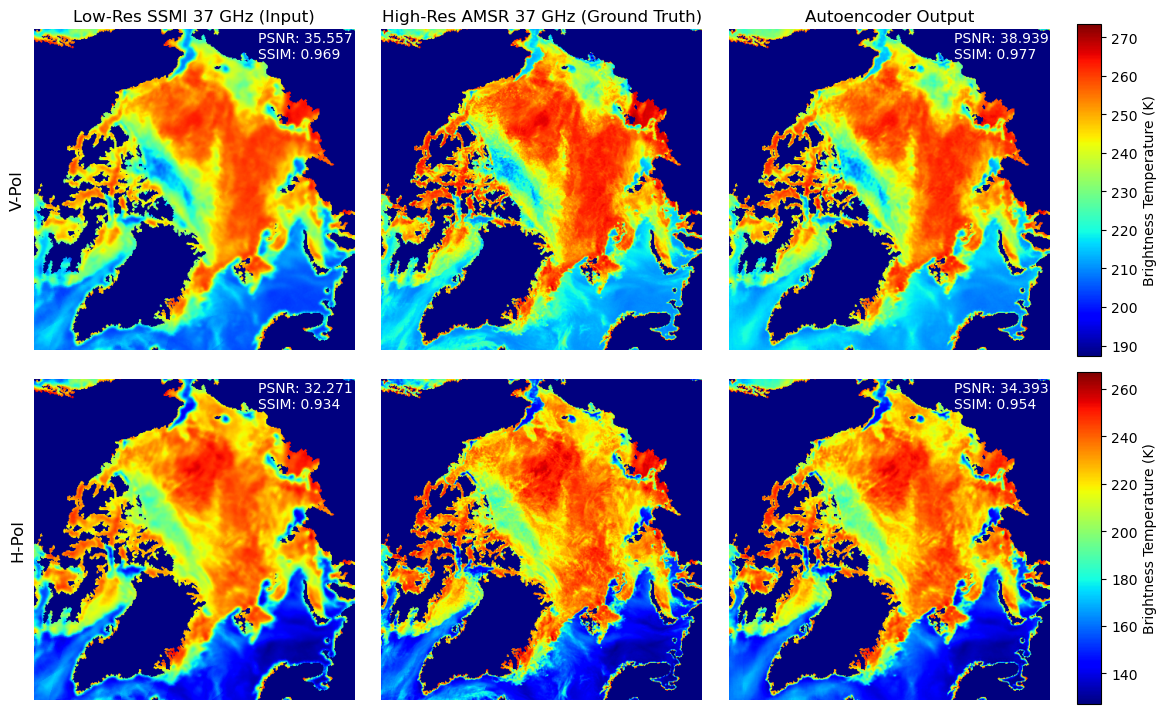

In [8]:
model_pth = "trained_models/REDNet10_24h_batchsize8_samplesall_normalized.pth"
plot_single_sample(model_pth,
                   test_paths,
                   test_dataset,
                   sample_idx=125,
                   mask_land=True);
# plt.savefig("../figures/REDNet10_24h_batchsize8_samplesall_normalized_HRrange.png", bbox_inches="tight")


2020-05-24 12:00:00


/tmp/ipykernel_2011840/1367287516.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))


2025-05-09 09:48:00,836 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa19af110>
2025-05-09 09:48:00,836 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa19af110>
2025-05-09 09:48:00,836 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa19af110>
2025-05-09 09:48:00,841 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa18c6900>
2025-05-09 09:48:00,841 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa18c6900>
2025-05-09 09:48:00,841 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa18c6900>


/tmp/ipykernel_2011840/1367287516.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, .92])


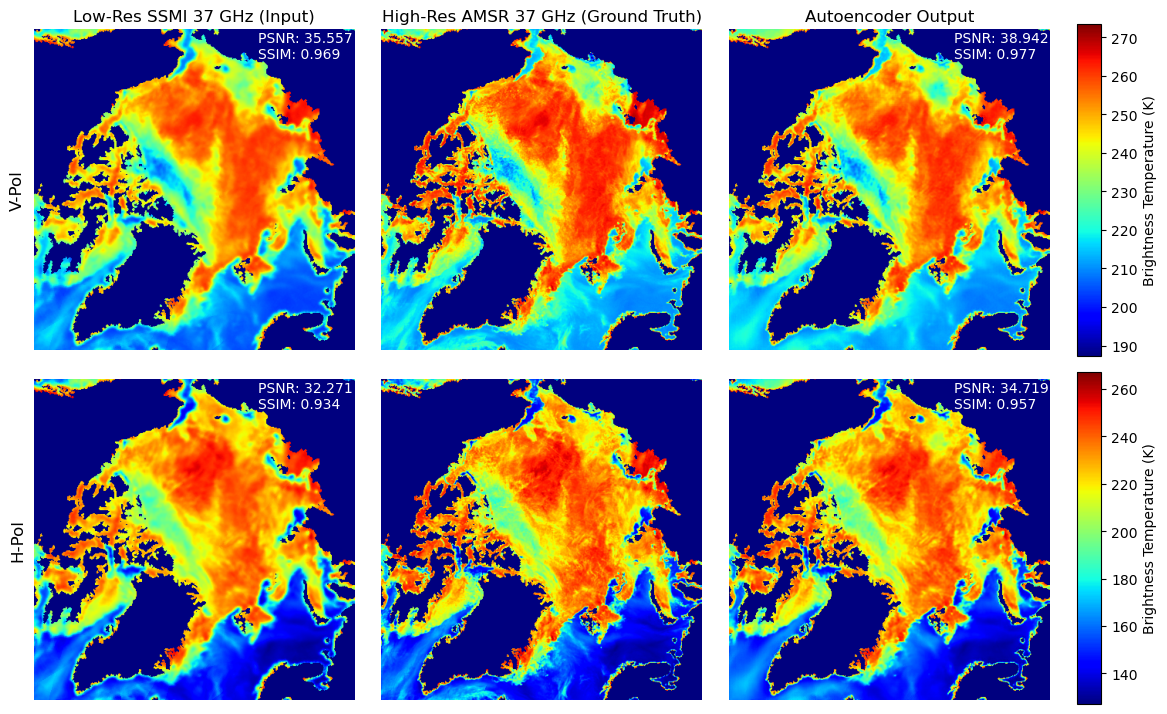

In [16]:
model_pth = "trained_models/REDNet20_24h_batchsize8_samplesall_normalized.pth"
plot_single_sample(model_pth,
                   test_paths,
                   test_dataset,
                   sample_idx=125,
                   mask_land=True);

2020-05-24 12:00:00


/tmp/ipykernel_2011840/1367287516.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))


2025-05-09 09:48:06,822 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa1c0c650>
2025-05-09 09:48:06,822 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa1c0c650>
2025-05-09 09:48:06,822 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa1c0c650>
2025-05-09 09:48:06,827 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa19710a0>
2025-05-09 09:48:06,827 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa19710a0>
2025-05-09 09:48:06,827 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa19710a0>


/tmp/ipykernel_2011840/1367287516.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, .92])


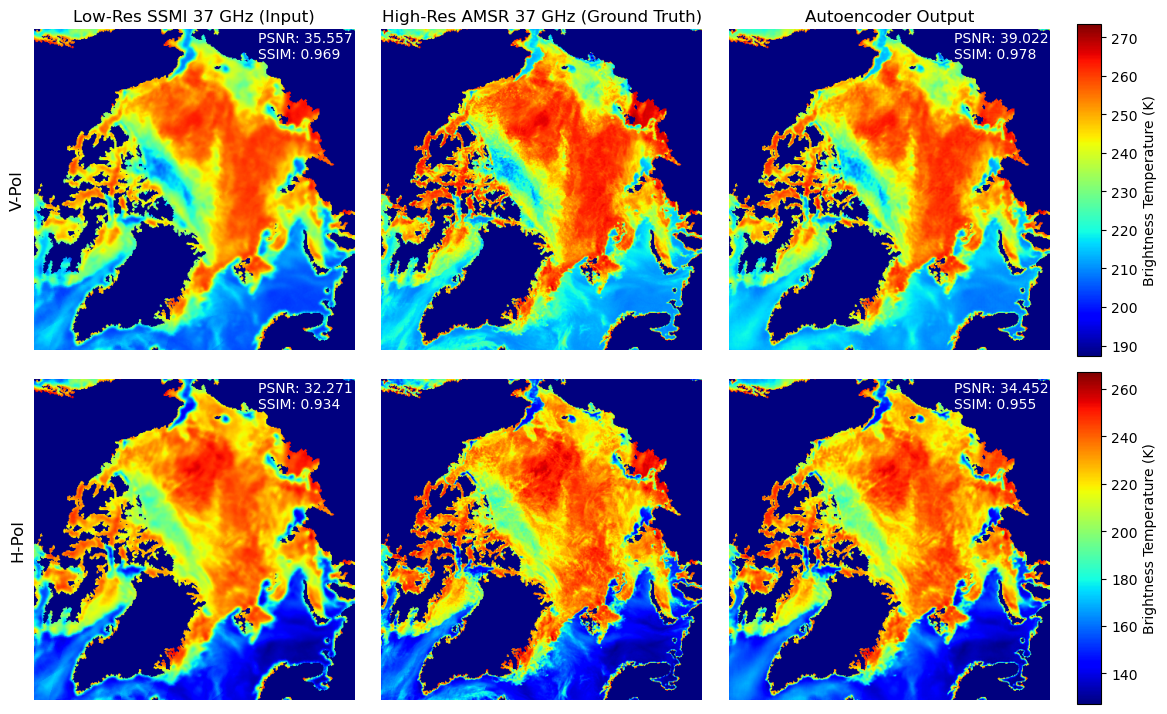

In [17]:
model_pth = "trained_models/REDNet30_24h_batchsize8_samplesall_normalized.pth"
plot_single_sample(model_pth,
                   test_paths,
                   test_dataset,
                   sample_idx=125,
                   mask_land=True);

# MASKED LOSS functions results

2020-05-24 12:00:00


/tmp/ipykernel_2011840/1367287516.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))


2025-05-09 09:48:09,118 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa202cb90>
2025-05-09 09:48:09,118 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa202cb90>
2025-05-09 09:48:09,118 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa202cb90>
2025-05-09 09:48:09,123 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa1a614f0>
2025-05-09 09:48:09,123 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa1a614f0>
2025-05-09 09:48:09,123 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa1a614f0>


/tmp/ipykernel_2011840/1367287516.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, .92])


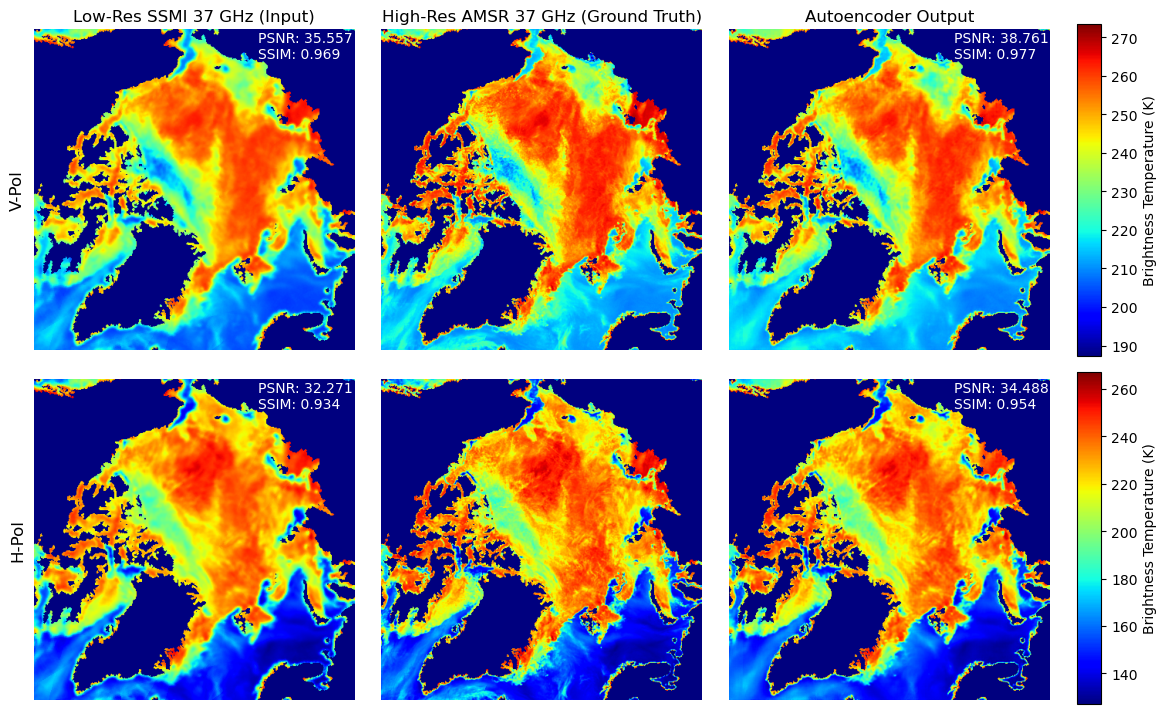

In [18]:
model_pth = "trained_models/REDNet10_24h_batchsize8_samplesall_normalized_masked_loss.pth"
plot_single_sample(model_pth,
                   test_paths,
                   test_dataset,
                   sample_idx=125,
                   mask_land=True);

2020-05-24 12:00:00


/tmp/ipykernel_2011840/1367287516.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))


2025-05-09 09:48:13,002 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa3c33d10>
2025-05-09 09:48:13,002 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa3c33d10>
2025-05-09 09:48:13,002 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa3c33d10>
2025-05-09 09:48:13,008 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa3cff2c0>
2025-05-09 09:48:13,008 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa3cff2c0>
2025-05-09 09:48:13,008 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa3cff2c0>


/tmp/ipykernel_2011840/1367287516.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, .92])


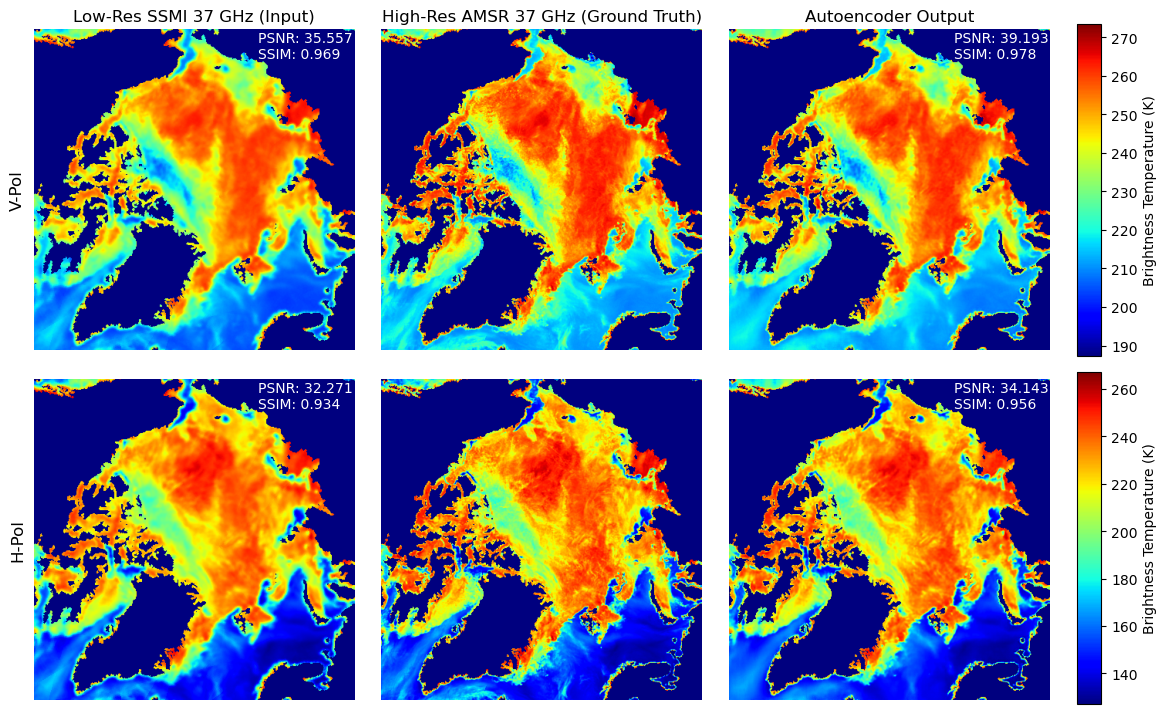

In [19]:
model_pth = "trained_models/REDNet20_24h_batchsize8_samplesall_normalized_masked_loss.pth"
plot_single_sample(model_pth,
                   test_paths,
                   test_dataset,
                   sample_idx=125,
                   mask_land=True);

2020-05-24 12:00:00


/tmp/ipykernel_2011840/1367287516.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))


2025-05-09 09:48:19,217 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa3b20410>
2025-05-09 09:48:19,217 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa3b20410>
2025-05-09 09:48:19,217 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa3b20410>
2025-05-09 09:48:19,222 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa3d14a40>
2025-05-09 09:48:19,222 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa3d14a40>
2025-05-09 09:48:19,222 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fdaa3d14a40>


/tmp/ipykernel_2011840/1367287516.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, .92])


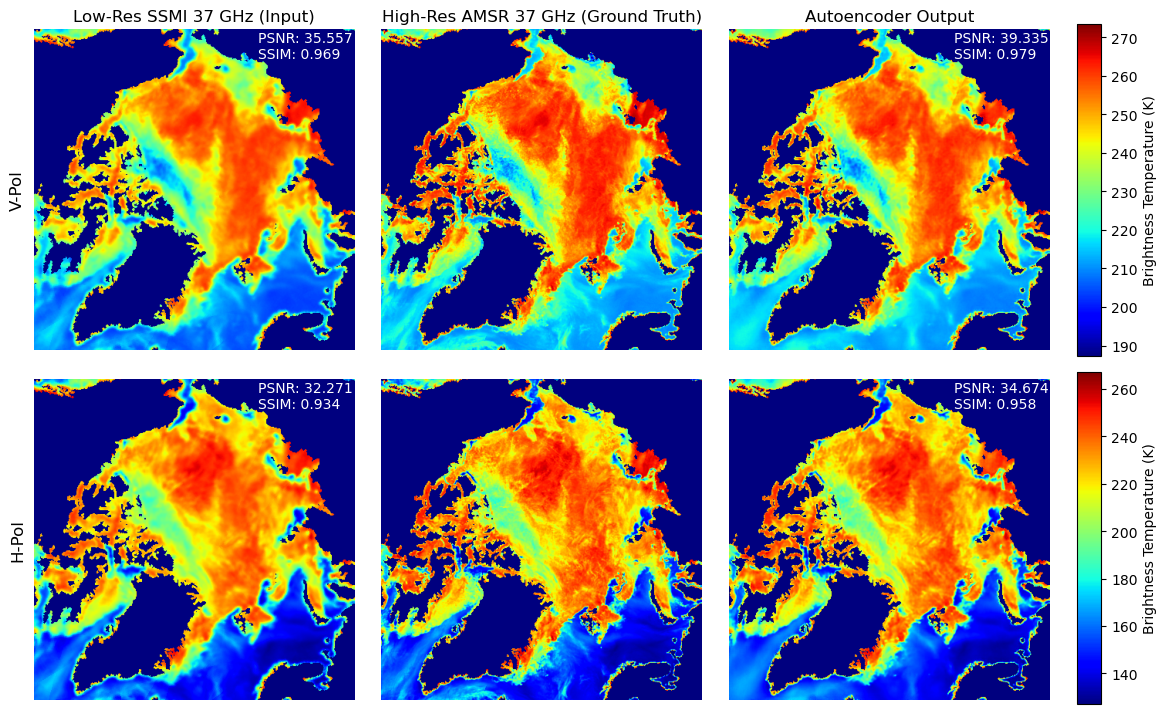

In [20]:
model_pth = "trained_models/REDNet30_24h_batchsize8_samplesall_normalized_masked_loss.pth"
plot_single_sample(model_pth,
                   test_paths,
                   test_dataset,
                   sample_idx=125,
                   mask_land=True);

# Plotting larger color range to show where autoencoder goes wrong

In [4]:
plt.rcParams.update({'font.size': plt.rcParams['font.size'] + 1})

In [11]:
def plot_single_sample_full_range(model_pth, test_paths, test_dataset, sample_idx, device="cuda" if torch.cuda.is_available() else "cpu", mask_land =False, denormalize = True):
    """
    Plot a single test sample's high-resolution ground truth and model output.
    """
    time = test_paths[sample_idx].split("_")[-1].replace(".nc","")
    dt = datetime.strptime(str(time), "%Y%m%d%H")
    dt.strftime("%Y-%m-%d %H:00")
    print(dt)
    if "REDNet10" in model_pth.split("_")[1].split("/"):
        model = REDNet10()
    elif "REDNet20" in model_pth.split("_")[1].split("/"):
        model = REDNet20()
    elif "REDNet30" in model_pth.split("_")[1].split("/"):
        model = REDNet30()

    model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))
    model.eval()  # Set the model to evaluation mode

    # Get a single test sample
    low_res, high_res = test_dataset[sample_idx]

    # Convert to batch format and move to device
    low_res_tensor = low_res.clone().detach().unsqueeze(0).to(device)
    high_res_tensor = high_res.clone().detach().unsqueeze(0).to(device)

    # Run model inference
    with torch.no_grad():
        output = model(low_res_tensor)

    # Move data back to CPU and convert to NumPy
    if denormalize:
        low_res = test_dataset.denormalize(low_res_tensor.squeeze(0)).cpu().numpy()
        high_res = test_dataset.denormalize(high_res_tensor.squeeze(0)).cpu().numpy()
        output = test_dataset.denormalize(output.squeeze(0)).cpu().numpy()
    else:
        low_res = low_res_tensor.squeeze(0).cpu().numpy()
        high_res = high_res_tensor.squeeze(0).cpu().numpy()
        output = output.squeeze(0).cpu().numpy()

    filtered_low_res_v = low_res[0][low_res[0] > 0]
    filtered_high_res_v = high_res[0][high_res[0] > 0]
    combined_filtered_v = np.concatenate([filtered_low_res_v, filtered_high_res_v])
    v_min = np.min(combined_filtered_v)
    v_max = np.max(combined_filtered_v)

    filtered_low_res_h = low_res[1][low_res[1] > 0]
    filtered_high_res_h = high_res[1][high_res[1] > 0]
    combined_filtered_h = np.concatenate([filtered_low_res_h, filtered_high_res_h])
    h_min = np.min(combined_filtered_h)
    h_max = np.max(combined_filtered_h)

    if mask_land:
        output[0][output[0] < v_min] = 0
        output[1][output[1] < h_min] = 0

    fig, axs = plt.subplots(1, 2, figsize=(6.4, 3.2))

    v_min = h_min = 0


    im2 = axs[0].imshow(high_res[0], cmap='turbo', vmin=v_min, vmax=v_max)  # Ground Truth
    axs[0].axis('off')
    axs[0].set_title("High-Res Ground Truth")

    im3 = axs[1].imshow(output[0], cmap='turbo', vmin=v_min, vmax=v_max)  # Autoencoder Output
    axs[1].axis('off')
    axs[1].set_title("REDNet")


    axs[0].annotate("V-Pol", xy=(-0.05, 0.5), xycoords='axes fraction', fontsize=12, ha='center', va='center', rotation=90)
    # # axs[1].annotate("H-Pol", xy=(-0.05, 0.5), xycoords='axes fraction', fontsize=12, ha='center', va='center', rotation=90)
    # # Add colorbars outside the plot
    # cbar_ax1 = fig.add_axes([0.9, 0.1, 0.02, 0.720])  # Top row , fraction=0.04, pad=0.04, shrink= 1.05)
    # # cbar_ax2 = fig.add_axes([0.9, 0.025, 0.02, 0.415])  # Bottom row
    # fig.colorbar(im2, cax=cbar_ax1, label='Brightness Temperature (K)')
    # # fig.colorbar(im5, cax=cbar_ax2, label='Brightness Temperature (K)')
    # # Adjust layout to avoid overlap
    # plt.tight_layout(rect=[0, 0, .9, .92])


    # Add colorbar
    cbar = fig.colorbar(im2, ax=axs, orientation='vertical', fraction=0.04, pad=0.04, shrink= 1.01)
    cbar.set_label("Brightness Temperature (K)")

    # Move colorbar down by adjusting its position
    cbar_ax = cbar.ax
    pos = cbar_ax.get_position()
    # Modify the y-position (second value) and height (fourth value) slightly
    cbar_ax.set_position([pos.x0, pos.y0 - 0.02, pos.width, pos.height])

    plt.tight_layout(rect=[0, 0, .89, .95])

2020-05-24 12:00:00


/tmp/ipykernel_227755/2104669289.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))


2025-05-23 11:04:03,485 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f130fd6e750>
2025-05-23 11:04:03,485 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f130fd6e750>


/tmp/ipykernel_227755/2104669289.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .89, .95])


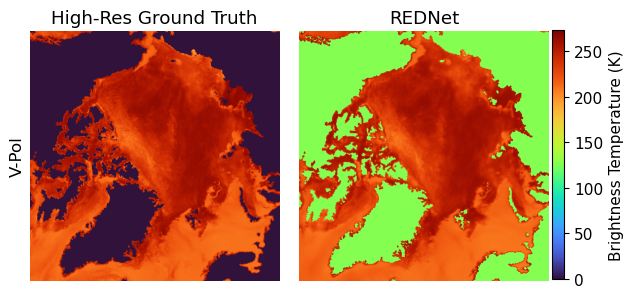

In [13]:
model_pth = "trained_models/REDNet10_24h_batchsize8_samplesall_normalized.pth"
plot_single_sample_full_range(model_pth,
                   test_paths,
                   test_dataset,
                   sample_idx=125,
                   mask_land=False);
plt.savefig("../final_figures/autoencoder_nan_issue.png", bbox_inches="tight")
